# Import relevant modules and data

In [1]:
# Import relevant modules
import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import os
import sys
import warnings
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.feature_selection import RFE

/Users/clarerigby/anaconda3/envs/fiverr_imtyjb_banks/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load modified & cleaned personal loan data into a Pandas DataFrame
df_loan_data = pd.read_pickle('df_loan_data.pkl')

# Transform data to suit the LGBM algorithm

LGBM models do not require scaling, even though the data is pre-scaled from the data_preparation notebook.

LGBM models do perform better with balanced classes (and this data has reasonably strong imbalance). This re-balancing will be handled within the model parameters

# Perform RFE to determine the ideal feature set for this model

In [3]:
# Load tuned best parameters from full-feature model
with open('LGBM_best_params.pkl', 'rb') as file:
    params = pickle.load(file)

In [4]:
# Suppress LightGBM UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="lightgbm")

In [5]:
# Define the target variable
target_variable = 'personal_loan'

In [6]:
# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

In [7]:
# Initialize the RFE selector
model = lgb.LGBMClassifier()
rfe = RFE(model)

In [8]:
# Lists to store results
num_features_list = []
AUC_list = []

In [9]:
# Define a custom function for evaluating AUC with lgb.train
def evaluate_auc(X, y, params):
    train_data = lgb.Dataset(X, label=y)
    bst = lgb.train(params, train_data)
    y_pred = bst.predict(X)
    return roc_auc_score(y, y_pred)

In [10]:
# Loop through the feature elimination process
for i in range(1, len(X.columns) + 1):
    rfe.n_features_to_select = i
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]  # Get the selected features

    # Apply SMOTE for class balancing
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X[selected_features], y)

    # Evaluate model performance with AUC
    AUC = evaluate_auc(X_resampled, y_resampled, params)

    # Store results
    num_features_list.append(i)
    AUC_list.append(AUC)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 1
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

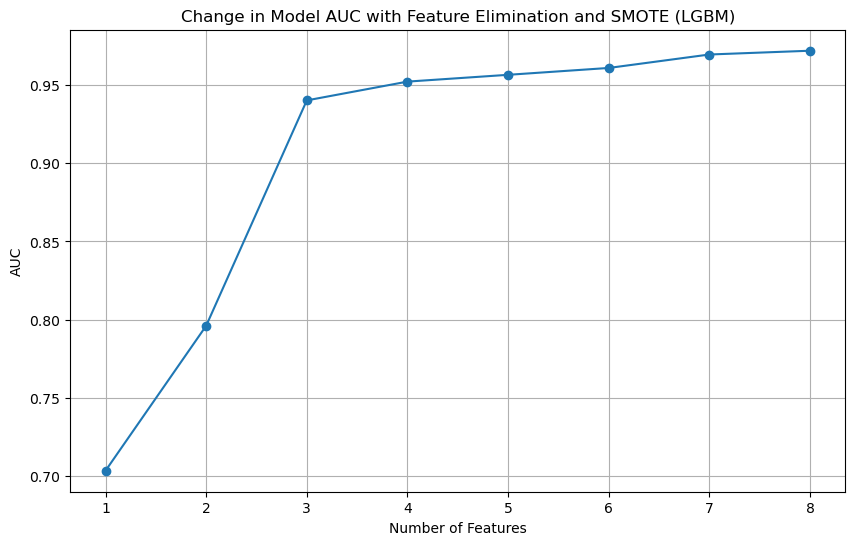

In [11]:
# Plot the change in AUC as features are eliminated
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, AUC_list, marker='o')
plt.xticks(np.arange(len(X.columns))+1)
plt.title('Change in Model AUC with Feature Elimination and SMOTE (LGBM)')
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

In [12]:
# Based on the LGBM RFE analysis, we should keep the following 3 features
rfe.n_features_to_select = 3
rfe.fit(X, y)
selected_feats = X.columns[rfe.support_]
print(selected_feats)

Index(['income', 'fin_exposure', 'fin_maturity'], dtype='object')


# Optimize the model with reduced features

In [13]:
# Implement feature reduction
df_loan_data = df_loan_data.loc[:, list(selected_feats) + [target_variable]]

In [14]:
# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

In [15]:
# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [16]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.7),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),  # Adjust the range as needed
    }

    auc_scores = []

    # Perform cross-validation
    for train_index, valid_index in skf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # Apply SMOTE for class balancing
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Create a LightGBM Dataset
        train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

        # Redirect output to null device to suppress all output
        devnull = open(os.devnull, 'w')
        stdout_backup = sys.stdout
        sys.stdout = devnull

        # Train the model with custom early stopping and 'log_evaluation' callback
        callbacks = [lgb.callback.log_evaluation(period=1)]
        bst = lgb.train(params, train_data, valid_sets=[valid_data], callbacks=callbacks)

        # Restore the standard output
        sys.stdout = stdout_backup

        # Evaluate the model on the validation set
        auc = bst.best_score['valid_0']['auc']
        auc_scores.append(auc)

    # Calculate the mean AUC score across cross-validation folds
    mean_auc = np.mean(auc_scores)
    return mean_auc

In [17]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-10-13 23:51:38,595] A new study created in memory with name: no-name-17a12a6f-9277-4fc0-a7fb-6c53bee2802d
[I 2023-10-13 23:51:40,525] Trial 0 finished with value: 0.9140354767184036 and parameters: {'learning_rate': 0.06568812366640493, 'n_estimators': 188, 'max_depth': 5, 'subsample': 0.6943741174256658, 'feature_fraction': 0.6428916364426795, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 0 with value: 0.9140354767184036.
[I 2023-10-13 23:51:42,213] Trial 1 finished with value: 0.9147862774082286 and parameters: {'learning_rate': 0.06755707277400878, 'n_estimators': 178, 'max_depth': 5, 'subsample': 0.6534045582077288, 'feature_fraction': 0.6404107419574623, 'num_leaves': 36, 'min_child_samples': 7}. Best is trial 1 with value: 0.9147862774082286.
[I 2023-10-13 23:51:43,161] Trial 2 finished with value: 0.9194740083764474 and parameters: {'learning_rate': 0.09413994196952294, 'n_estimators': 156, 'max_depth': 4, 'subsample': 0.6372850292370107, 'feature_fraction': 0

In [18]:
# Get the best hyperparameters
best_params = study.best_params
print('Best Hyperparameters: {}'.format(best_params))

Best Hyperparameters: {'learning_rate': 0.04726261778681594, 'n_estimators': 264, 'max_depth': 3, 'subsample': 0.6367754140496615, 'feature_fraction': 0.6068032270734448, 'num_leaves': 20, 'min_child_samples': 19}


In [19]:
# Save the finalized best params
with open('LGBM_reduced_best_params.pkl', 'wb') as file:
    pickle.dump(best_params, file)

# Train and evaluate a model using the best hyperparameters

In [20]:
# Initialize lists to store results from best model
auc_scores = []

In [25]:
# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to oversample the minority class
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Create a LightGBM Dataset
    train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the LightGBM model
    num_round = 100
    bst = lgb.train(best_params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10, verbose_eval=False)

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    # Calculate ROC AUC score
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7216, number of used features: 3
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [26]:
# Calculate the mean AUC score across cross-validation folds
mean_auc = np.mean(auc_scores)
print('Mean AUC: {}'.format(mean_auc))

Mean AUC: 0.9203713968957871
